GAN 은 생성된 이미지가 실제 이미지와 통계적으로 거의 구분이 되지 않도록 강제하여 아주 실제 같은 합성 이미지를 생성한다. 

GAN을 직관적으로 이해하는 방법은 가짜 피카소 그림을 만드는 위조범을 생각하는 것이다. 처음에 위조범은 형편없이 위조한다. 진짜 피카소 그림과 위조품을 섞어서 그림 판매상에게 보여준다. 판매상은 각 그림이 진짜인지 평가하고 어떤 것이 피카소 그림 같은지 위조범에게 피드백을 준다. 위조범은 자신의 화실로 돌아가 새로운 위조품을 준비한다. 시간이 지남에 따라 위조범은 피카소의 스타일을 모방하는 데 점점 능숙해진다. 그림 판매상은 위조품을 구분하는 데 점점 더 전문가가 된다. 결국 아주 휼륭한 피카소 위조품을 만들어 낼 것이다.

위조범 네트워크와 전문가 네트워크가 바로 GAN이다. 두 네트워크는 상대를 이기기 위해 훈련한다. GAN의 네트워크는 2개는 다음과 같다.

- 생성자 네트워크(Generator network) : 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩한다.
- 판별자 네트워크(Discriminartor network)(또는 상대 네트워크) : 이미지(실제 또는 합성 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지, 생성자 네트워크가 만든 이미지인지 판별한다.

생성자 네트워크는 판별자 네트워크를 속이도록 훈련한다. 훈련이 계속될수록 점점 더 실제와 같은 이미지를 생성하게 된다. 실제 이미지와 구분할 수 없는 인공적인 이미지를 만들어 판별자 네트워크가 두 이미지를 동일하게 보도록 만든다. 한편 판별자 네트워크는 생성된 이미지가 실제인지 판별하는 기준을 설정하면서 생성자의 능력 향상에 적응해 간다. 훈련이 끝나면 생성자는 입력 공간에 있는 어떤 포인트를 그럴듯한 이밎로 변환한다. VAE와 달리 이 잠재 공간은 의미 있는 구조를 보장하지 않는다. 특히 이 공간은 연속적이지 않다.

놀랍게도 GAN은 최적화의 최솟값이 고정되지 않은 시스템이다. 이 책에서 다루는 어떤 훈련 설정과도 다르다. 보통 경사 하강법은 고정된 손실 공간에서 언덕을 내려온느 방법이다. GAN에서는 언덕을 내려오는 매 단계가 조금씩 전체 공간을 바꾼다. 최적화 과정이 최솟값을 찾는 것이 아니라 두 힘 간의 평형점을 찾는 다이나믹 시스템이다. 이런 이유로 GAN은 훈련하기 어렵기로 유명하다. GAN을 만들려면 모델 구조와 훈련 파라미터를 주의 깊게 많이 조정해야한다.

![](http://www.miketyka.com/projects/faces/00128000.jpg.cover.jpg)

![](http://www.miketyka.com/projects/faces/00734000.jpg.cover.jpg)

> http://www.miketyka.com/?s=faces 에서 보는 GAN으로 만든 이미지

## GAN 구현 방법

간단한 형태의 GAN을 설명하겠다. 구체적인 구현은 심층 합성곱 GAN(DCGAN)을 구현할 것이다. 생성자와 판별자가 심층 컨브넷이다. 특히 생성자에서 이미지 업샘플링을 위해서 Conv2DTranspose 층을 사용한다.

CIFAR10 데이터셋의 이미지로 GAN을 훈련하겠다. 이 데이터셋은 32X32 크기의 RGB 이미지 5만 개로 이루어져 있고 10개의 클래스를 가진다. (클래스마다 5,000개의 이미지가 있다.) 문제를 간단하게 만들기 위해 "frog"클래스의 이미지만 사용하겠다.

GAN의 구조는 다음과 같다.

1. generator 네트워크는 (latent_dim), 크기의 벡터를 (32, 32, 3) 크기의 이미지로 매핑한다.
2. discriminator 네트워크는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑한다.
3. 생성자와 판별자를 연결하는 gan 네트워크를 만든다. gan(x) = discriminator(generator(x))이다. 이 gan 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑한다. 즉 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지 평가한다. 
4. "진짜"/"가짜" 레이블과 함께 진짜 이미지와 가자 이미지 샘플을 사용하여 판별자를 훈련한다. 일반적인 이미지 분류 모델을 훈련하는 것과 동일하다.
5. 생성자를 훈련하려면 gan 모델의 손실에 대해 생성자 가중치의 그래디언트를 사용한다. 이 말은 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻이다. 다른 말로 하면 판별자를 속이도록 생성자를 훈련한다.

## 훈련 방법

GAN을 훈련하고 튜닝하는 과정은 어렵기로 유명하다. 알아 두어야 할 몇 가지 유용한 기법이 있다. 딥러닝의 대부분이 그렇듯이 이는 과학보다는 연금술에 가깝다. 이런 기법들은 이론에 바탕을 둔 지침이 아니고 경험을 통해 발견된 것이다. 실제 일어난 현상을 직관적으로 이해하는 수준에서 검증되었다. 모든 문제에 반드시 적용해야 하는 것은 아니지만 경험상 잘 작동한다고 알려져 있다.

다음은 이 절에서 GAN 생성자와 판별자를 구현하는 데 사용할 몇 가지 기법이다. 이 목록이 GAN에 관련된 전체 팁이 아니다. GAN 논문들에서 더 많은 방법을 볼 수 있다.

- 생성자의 마지막 활성화로 다른 종류의 모델에서 널리 사용되는 sigmoid 대신 tanh 함수를 사용한다.
- 균등 분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링한다.
- 무작위성은 모델을 견고하게 만든다. GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 가능성이 높다. 훈련하는 동안 무작위성을 주입하면 이를 방지하는 데 도움이 된다. 무작위성은 두 가지 방법으로 주입한다. 판별자에 드롭아웃을 사용하거나 판별자를 위해 레이블에 랜덤 노이즈를 추가한다.
- 희소한 그래디언트는 GAN 훈련을 방해할 수 있다. 딥러닝에서 희소는 종종 바람직한 현상이지만 GAN에서는 그렇지 않다. 그래디언트를 희소하게 만들 수 있는 것은 최대풀링 연산과 ReLUJ 활성화 두 가지이다. 최대 풀링 대신 스트라이드 합성곱을 사용하여 다운샘플링을 하는 것이 좋다. 또 ReLU 활성화 대신 LeakyReLU 층을 사용하라. ReLU와 비슷하지만 음수의 활성화 값을 조금 허용하기 때문에 희소가 조금 완화된다.
- 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타난다. 이를 해결하기 위해 생성자와 판별자에서 스트라이드 Conv2DTranpose나 Conv2D를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기를 사용한다.

## 생성자

먼지 벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링된다)를 후보 이미지로 변환하는 generator 모델을 만들어 보자. GAN에서 발생하는 많은 문제 중 하나는 생성자 양쪽에 모두 드롭아웃을 사용하는 것이 해결 방법이 될 수 있다.

In [1]:
import keras
from keras import layersrs
import numpy as np

In [2]:
latent_dim = 32
height = 32
width  = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

## 판별자

다음은 후보 이미지(진짜 또는 가짜)를 입력으로 받고 2개의 클래스로 분류하는 discriminator 모델을 만들겠다. 이 클래스는 '생성된 이미지'또는 '훈련 세트에서 온 진짜 이미지'이다.

In [4]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

## 적대적 네트워크

마지막으로 생성자와 판별자를 연결하여 GAN을 설정한다. 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습한다. 이 모델은 잠재 공간의 포인트를 "진짜" 또는 "가짜"의 분류 결정으로 변환한다. 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지'이다. GAN을 훈련하는 것은 discriminator가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 generator의 가중치를 업데이트 하는 것이다. 훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요하다. GAN을 훈련할 때 가중치가 업데이트되지 않는다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 "진짜"를 예측하도록 훈련된다. 이것은 우리가 원하는 바가 아니다!

In [7]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## DCGAN 훈련 방법

이제 훈련을 시작한다. 훈련 반복의 내용을 요약 정리해 보겠다. 매 반복마다 다음을 수행한다.

1. 잠재 공간에서 무작위로 포인트를 뽑는다(랜덤 노이즈)
2. 이 랜덤 노이즈를 사용하여 generator에서 이미지를 생성한다.
3. 생성된 이미지와 진짜 이미지를 섞는다.
4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 discriminator를 훈련한다. 타깃은 "진짜(실제 이미지일 경우)" 또는 "가짜(생성된 이미지일 경우)"이다.
5. 잠재 공간에서 무작위로 새로운 포인트를 뽑는다.
6. 이 랜덤 벡터를 사용하여 gan을 훈련한다. 모든 타깃은 "진짜"로 설정한다. 판별자가 생성된 이미지를 모두 "진짜 이미지"라고 예측하도록 생성자의 가중치를 업데이트한다(gan)안에서 판별자는 동결되기 때문에 생성자만 업데이트한다) 결국 생성자는 판별자를 속이도록 훈련한다.

In [9]:
import os
from keras.preprocessing import image

In [11]:
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) + 
    (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './datasets/gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start : stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors,
                                misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        
        print('discriminator loss : ', d_loss)
        print('generative loss : ', d_loss)
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
                             'generated_frog' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
                             'real_frog'+str(step) + '.png'))

C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss :  0.6883102
generative loss :  0.6883102
discriminator loss :  0.7079845
generative loss :  0.7079845
discriminator loss :  0.6811552
generative loss :  0.6811552
discriminator loss :  0.68777305
generative loss :  0.68777305
discriminator loss :  0.68104184
generative loss :  0.68104184
discriminator loss :  0.6952647
generative loss :  0.6952647
discriminator loss :  0.6896124
generative loss :  0.6896124
discriminator loss :  0.69773656
generative loss :  0.69773656
discriminator loss :  0.691177
generative loss :  0.691177
discriminator loss :  0.69689035
generative loss :  0.69689035
discriminator loss :  0.6939559
generative loss :  0.6939559
discriminator loss :  0.6933508
generative loss :  0.6933508
discriminator loss :  0.7039848
generative loss :  0.7039848
discriminator loss :  0.69345075
generative loss :  0.69345075
discriminator loss :  0.69653356
generative loss :  0.69653356
discriminator loss :  0.7783613
generative loss :  0.7783613
discriminator 

훈련할 때 적대적 손실이 크게 증가하는 것을 볼지도 모른다. 반면에 판별자의 손실은 0으로 향한다. 결국 판별자가 생성자를 압도할 수 있다.

In [12]:
import matplotlib.pyplot as plt

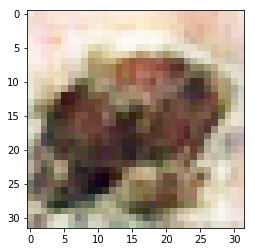

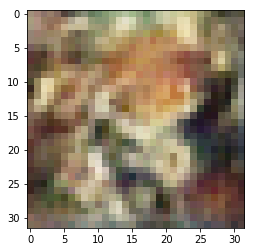

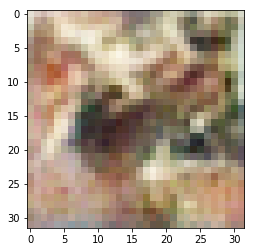

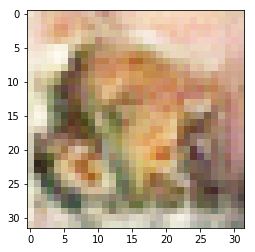

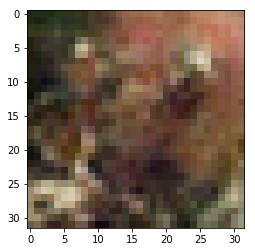

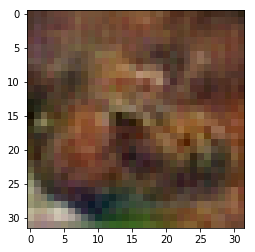

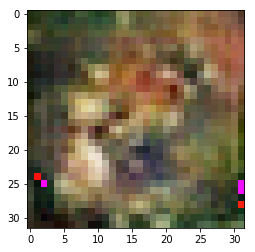

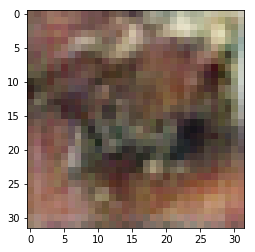

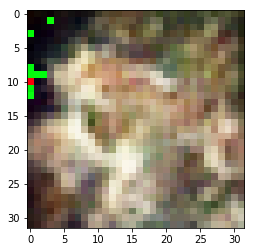

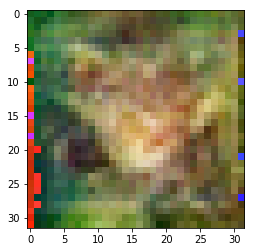

In [13]:
random_latent_vectors = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()